# **Final Exam for Deep Network Development course. First part (mandatory)**

This notebook contains the task to be solved in order to pass the exam.
This is the first part of the exam, which is compolsury in order to get a grade. It contains a task similar to what you have worked on during the semester, which consists on implementing a network architecture and a function.

Please note that, to **PASS** the Deep Network Development course you must **SUBMIT A SUCCESSFUL SOLUTION FOR THE FIRST PART**. If you **FAIL** the first part, you have the right to do the exam **ONE MORE TIME**. If you **FAIL AGAIN**, then unfortunately, you have failed the course. If you **PASS** the first part, then you get the weighted average of your quizzes and assignments as your final grade.

## Your information
Please fill the next cell with your information

**Full Name**:

**Neptun code:**

**Date:** 16/01/2024 9AM-10AM

## Task Description

#### Your task is to implement a custom architecture layers and the forward functions.

#### Afterwards, make sure to run the last cell code to check if your implementation is correct.

#### This task should be **SOLVED IN 1 HOUR** and submitted to Canvas (download the .ipynb file). Please note that after 1 hour, the Canvas exam assignment will be closed and you cannot submit your solution.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cpu")
device

device(type='cpu')

# Architecture

Please right click the image and "Open image in a new tab" to view it better with zoom. Or download it from here: https://drive.google.com/file/d/1I4GNCq7OnANpLfknHFox52wnzlBnvmTj/view?usp=sharing

<br>
<br>


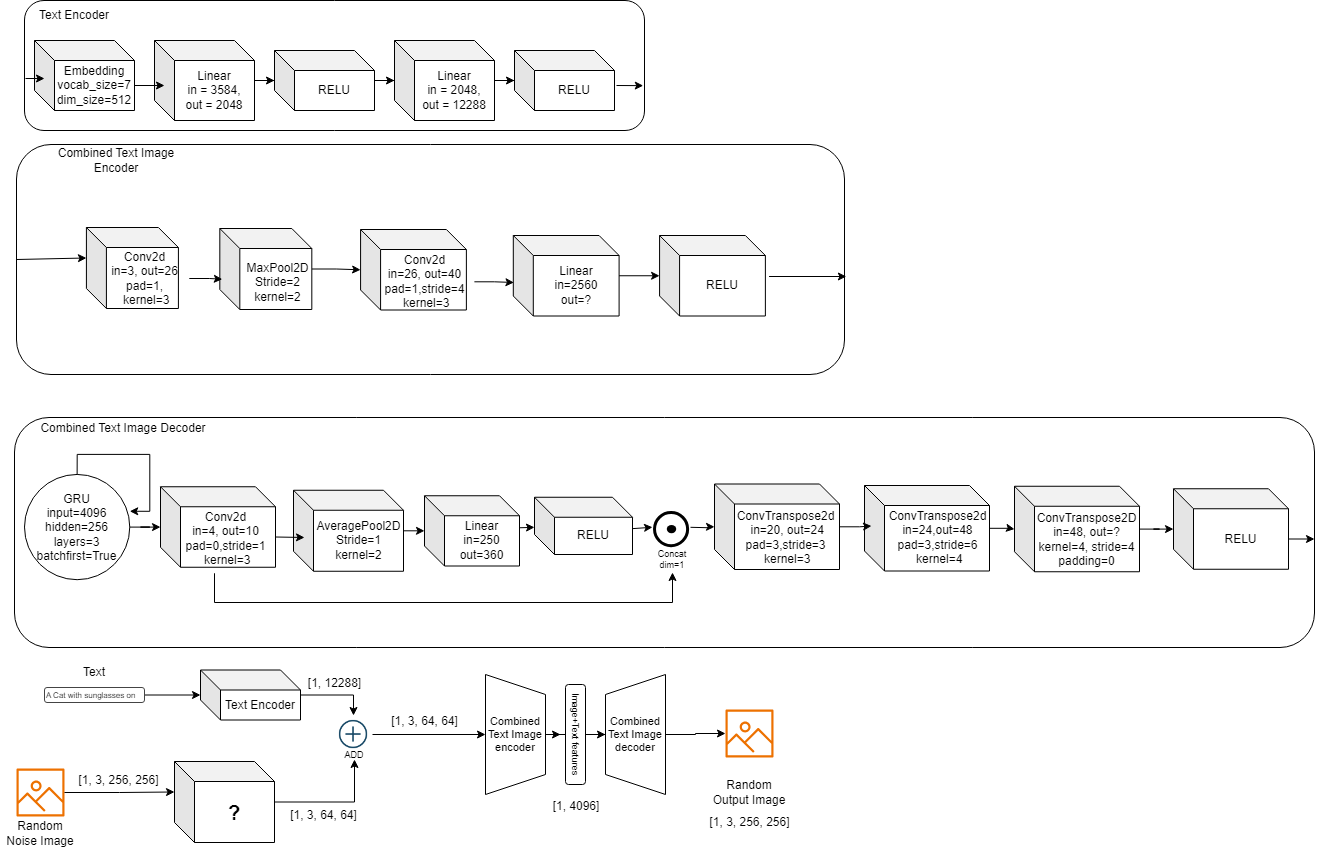

# Text Encoder

In [16]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size=7, embedding_dim=512):
        super(TextEncoder, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings=7, embedding_dim=512)

        # Feedforward layers
        self.fc1 = nn.Linear(in_features=3584, out_features=2048)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=2048, out_features=12288)
        self.relu2 = nn.ReLU()

    def forward(self, text):
        # Embedding layer
        embedded = self.embedding(text)
        print("embedded", embedded.shape)
        embedded = embedded.unsqueeze(0)  # Add batch dimension
        # Reshape embedding output to fit feedforward layer
        # Assuming text shape is (batch_size, sequence_length, embedding_dim)
        batch_size, seq_length, embedding_dim = embedded.size()
        embedded = embedded.view(batch_size, -1)  # Flatten into (batch_size, seq_length * embedding_dim)
        print("embedded reshape", embedded.shape)
        # Pass through feedforward layers
        x = self.fc1(embedded)
        print("fc1", x.shape)
        x = self.relu1(x)
        x = self.fc2(x)
        print("fc2", x.shape)
        x = self.relu2(x)

        return x



# Combined Text-Image Encoder

In [17]:
class CombinedTextImageEncoder(nn.Module):
    def __init__(self):
        super(CombinedTextImageEncoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=26, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=26, out_channels=40, kernel_size=3, padding=1, stride=4)
        self.fc = nn.Linear(in_features=2560, out_features=4096)
        self.relu = nn.ReLU()

    def forward(self, encoded_text):
        # Implement conv layers
        x = self.conv1(encoded_text)
        print("conv1", x.shape)
        x = self.pool(x)
        print("pool", x.shape)
        x = self.conv2(x)
        print("conv2", x.shape)

        # Reshape output to fit Linear
        x = x.view(x.size(0), -1)  # Flatten the tensor
        print("reshape", x.shape)
        # Add batch number to Linear's output
        x = self.fc(x)
        print("fc", x.shape)
        x = self.relu(x)

        return x
    
if __name__ == "__main__":
    image_model = CombinedTextImageEncoder()
    image_input = torch.randn(1, 3, 64, 64)  # Example input
    image_output = image_model(image_input)

    print("Image Input Shape:", image_input.shape)
    print("Image Output Shape:", image_output.shape)



conv1 torch.Size([1, 26, 64, 64])
pool torch.Size([1, 26, 32, 32])
conv2 torch.Size([1, 40, 8, 8])
reshape torch.Size([1, 2560])
fc torch.Size([1, 4096])
Image Input Shape: torch.Size([1, 3, 64, 64])
Image Output Shape: torch.Size([1, 4096])


In [18]:
class CombinedTextImageDecoder(nn.Module):
    def __init__(self):
        super(CombinedTextImageDecoder, self).__init__()
        self.gru = nn.GRU(input_size=4096, hidden_size=256, num_layers=3, batch_first=True)
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=3, stride=1, padding=0)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=1)
        self.fc = nn.Linear(in_features=250, out_features=360)
        self.relu = nn.ReLU()
        self.deconv1 = nn.ConvTranspose2d(in_channels=20, out_channels=24, kernel_size=3, stride=3, padding=3)
        self.deconv2 = nn.ConvTranspose2d(in_channels=24, out_channels=48, kernel_size=4, stride=6, padding=3)
        self.deconv3 = nn.ConvTranspose2d(in_channels=48, out_channels=3, kernel_size=4, stride=4, padding=0)
        self.relu1 = nn.ReLU()

    def forward(self, features):
        # GRU forward
        features = features.unsqueeze(1)  # Adding time dimension for GRU
        print("features", features.shape)
        gru_out, _ = self.gru(features)
        print("gru_out", gru_out.shape)

        # Reshape GRU output to fit Conv2D
        x = gru_out[:, -1, :].view(-1, 4, 8, 8)  # Assuming reshaping to (batch_size, channels, height, width)
        print("reshape", x.shape)
        # Conv2D and pooling layers
        y = self.conv1(x)
        print("conv1", y.shape)
        x = self.pool(y)
        print("pool", x.shape)
        # Fully connected layer and activation
        x = x.view(x.size(0), -1)  # Flatten
        print("reshape", x.shape)
        x = self.fc(x)
        print("fc", x.shape)
        x = self.relu(x)

        # Concatenation for deconvolution layers
        x = x.view(-1, 10, 6, 6)  # Adjust dimensions to fit ConvTranspose2d
        print("reshape", x.shape)
        x = torch.cat((x, y), dim=1)
        # Deconvolution layers
        x = self.deconv1(x)
        print("deconv1", x.shape)
        x = self.deconv2(x)
        print("deconv2", x.shape)
        x = self.deconv3(x)
        print("deconv3", x.shape)
        x = self.relu1(x)

        return x
if __name__ == "__main__":
    decoder_model = CombinedTextImageDecoder()
    decoder_input = torch.randn(1, 4096)  # Example input
    decoder_output = decoder_model(decoder_input)

    print("Decoder Input Shape:", decoder_input.shape)
    print("Decoder Output Shape:", decoder_output.shape)


features torch.Size([1, 1, 4096])
gru_out torch.Size([1, 1, 256])
reshape torch.Size([1, 4, 8, 8])
conv1 torch.Size([1, 10, 6, 6])
pool torch.Size([1, 10, 5, 5])
reshape torch.Size([1, 250])
fc torch.Size([1, 360])
reshape torch.Size([1, 10, 6, 6])
deconv1 torch.Size([1, 24, 12, 12])
deconv2 torch.Size([1, 48, 64, 64])
deconv3 torch.Size([1, 3, 256, 256])
Decoder Input Shape: torch.Size([1, 4096])
Decoder Output Shape: torch.Size([1, 3, 256, 256])


# Combining everything

In [22]:
class TextToImageModel(nn.Module):
    def __init__(self):
        super(TextToImageModel, self).__init__()
        self.textencoder = TextEncoder()
        self.encoder = CombinedTextImageEncoder()
        self.decoder = CombinedTextImageDecoder()
        self.conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=4, padding=0)

    def forward(self, text):
        text_features = self.textencoder(text)

        # Making random noise image
        image = torch.rand(256, 256, 3).numpy()
        
        image = (image * 255).astype(np.uint8)
        
        image = np.rollaxis(image, 2, 0)
    
        input_image = torch.from_numpy(image).float()  # Convert image to torch tensor
        input_image = torch.unsqueeze(input_image, dim=0)  # Add a batch dimension of 1
        

        # Do the block with the interrogation mark
        input_image = self.conv(input_image)
        print("input_image", input_image.shape)

        # Reshape features to fit addition
        text_features = text_features.view(-1, 3, 64, 64)
        print("text_features", text_features.shape)
        combined_features = text_features + input_image
        print("combined_features", combined_features.shape)

        # Pass through encoder and decoder
        encoded_features = self.encoder(combined_features)
        print("encoded_features", encoded_features.shape)
        output_image = self.decoder(encoded_features)
        print("output_image", output_image.shape)

        return output_image

# Trying Out the whole architecture DO NOT MODIFY THESE CELLS!!!!


In [23]:
text = "Brown fox jumps over the lazy dog"

# Simple preprocessing the text
word_to_ix = {"Brown": 0, "fox": 1, "jumps": 2, "over": 3, "the": 4, "lazy": 5, "dog":6}
input_tensor = torch.tensor(list(word_to_ix.values()), dtype=torch.long) # a tensor representing words by integers

In [24]:
model = TextToImageModel()
model = model.to(device)
output = model(input_tensor)
print(output.shape)
assert output.shape == (1,3,256,256)

embedded torch.Size([7, 512])
embedded reshape torch.Size([1, 3584])
fc1 torch.Size([1, 2048])
fc2 torch.Size([1, 12288])
input_image torch.Size([1, 3, 64, 64])
text_features torch.Size([1, 3, 64, 64])
combined_features torch.Size([1, 3, 64, 64])
conv1 torch.Size([1, 26, 64, 64])
pool torch.Size([1, 26, 32, 32])
conv2 torch.Size([1, 40, 8, 8])
reshape torch.Size([1, 2560])
fc torch.Size([1, 4096])
encoded_features torch.Size([1, 4096])
features torch.Size([1, 1, 4096])
gru_out torch.Size([1, 1, 256])
reshape torch.Size([1, 4, 8, 8])
conv1 torch.Size([1, 10, 6, 6])
pool torch.Size([1, 10, 5, 5])
reshape torch.Size([1, 250])
fc torch.Size([1, 360])
reshape torch.Size([1, 10, 6, 6])
deconv1 torch.Size([1, 24, 12, 12])
deconv2 torch.Size([1, 48, 64, 64])
deconv3 torch.Size([1, 3, 256, 256])
output_image torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
